In [8]:
import json
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
import pickle
import collections
from pandas.io.json import json_normalize
import re
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

for _, _, filenames in os.walk('hotpot-data/'):
    for filename in filenames:
        print(os.path.join('hotpot-data/', filename))

hotpot-data/hotpot_train_v1.1.json
hotpot-data/hotpot_train_v1.1.json.1
hotpot-data/hotpot_dev_distractor_v1.json
hotpot-data/hotpot_dev_distractor_v1.json.1


In [12]:
df = pd.read_json('hotpot-data/hotpot_train_v1.1.json')

In [13]:
df

,supporting_facts,level,question,context,answer,_id,type
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge
3,"[[Peggy Seeger, 0], [Peggy Seeger, 1], [Ewan M...",medium,What nationality was James Henry Miller's wife?,"[[Moloch: or, This Gentile World, [Moloch: or,...",American,5a82171f5542990a1d231f4a,bridge
4,"[[Cadmium chloride, 1], [Ethanol, 0]]",medium,Cadmium Chloride is slightly soluble in this c...,"[[Cadmium chloride, [Cadmium chloride is a whi...",alcohol,5a84dd955542997b5ce3ff79,bridge
...,...,...,...,...,...,...,...
90442,"[[Kerry Remsen, 1], [Bert Remsen, 0]]",medium,Kerry Remsen is the daughter of an actor with ...,"[[Kerry Remsen, [Kerry Remsen is an American a...",American,5a8f8db25542997ba9cb32b9,bridge
90443,"[[Northshore Mall, 0], [Northshore Mall, 4], [...",easy,"Who manages both Northshore Mall in Peabody, M...","[[Green Tree Mall, [Green Tree Mall is a shopp...",Simon Property Group,5ae4f3615542993aec5ec0fd,bridge
90444,"[[Charlee Johnson, 4], [DreamWorks, 0]]",medium,Charlee Johnson was part of a band that signed...,"[[Simon M. Woods, [Simon M. Woods is a British...",Amblin Partners,5a903fc95542990a984935bd,bridge
90445,"[[Salt to the Sea, 1], [MV Wilhelm Gustloff, 0]]",medium,What is the ship that sank in the Baltic sea a...,[[The I.V. Stalin White Sea – Baltic Sea Canal...,"MV ""Wilhelm Gustloff",5ab56e71554299494045efc8,bridge


In [43]:
def print_qa(i):
    print("Question: " + df.iloc[i]['question'])
    print("\nAnswer: " + df.iloc[i]['answer'])
    print("\nSupporting Facts: " + df.iloc[i]['supporting_facts'][0][0] + " | " + df.iloc[i]['supporting_facts'][1][0])
    print("\nContext:\n\n" + " ".join(next(x[1] for x in df.iloc[i]['context'] if x[0] == df.iloc[i]['supporting_facts'][0][0])) + "\n\n" + " ".join(next(x[1] for x in df.iloc[i]['context'] if x[0] == df.iloc[i]['supporting_facts'][1][0])))

In [49]:
print_qa(5)

Question: Which tennis player won more Grand Slam titles, Henri Leconte or Jonathan Stark?

Answer: Jonathan Stark

Supporting Facts: Jonathan Stark (tennis) | Jonathan Stark (tennis)

Context:

Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994.

Jonathan Stark (born April 3, 1971) is a former professional tennis player from the United States.  During his career he won two Grand Slam doubles titles (the 1994 French Open Men's Doubles and the 1995 Wimbledon Championships Mixed Doubles).  Stark reached the World No. 1 doubles ranking in 1994.


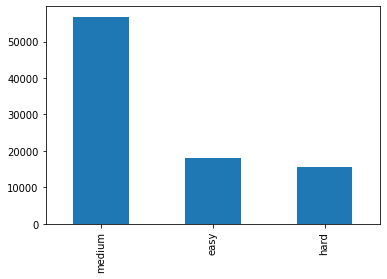

In [19]:
pd.value_counts(df['level']).plot.bar()

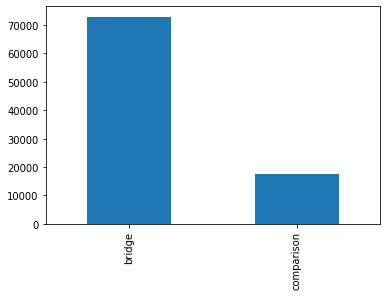

In [20]:
pd.value_counts(df['type']).plot.bar()

In [16]:
validation_df = pd.read_json('hotpot-data/hotpot_dev_distractor_v1.json')

In [17]:
validation_df

,_id,answer,question,supporting_facts,context,type,level
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard
1,5a8c7595554299585d9e36b6,Chief of Protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard
2,5a85ea095542994775f606a8,Animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard
3,5adbf0a255429947ff17385a,no,Are the Laleli Mosque and Esma Sultan Mansion ...,"[[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]","[[Esma Sultan (daughter of Abdülaziz), [Esma S...",comparison,hard
4,5a8e3ea95542995a26add48d,"Greenwich Village, New York City","The director of the romantic comedy ""Big Stone...","[[Big Stone Gap (film), 0], [Adriana Trigiani,...","[[Just Another Romantic Wrestling Comedy, [Jus...",bridge,hard
...,...,...,...,...,...,...,...
7400,5ab92307554299753720f72d,Yasir Hussain,What Pakistani actor and writer from Islamabad...,"[[Coke Kahani, 0], [Coke Kahani, 1], [Yasir Hu...","[[Coke Kahani, [Coke Kahani (Urdu: کوک کہانی‎ ...",bridge,hard
7401,5abba3b1554299642a094aed,no,Are both Volvic and Canfield's Diet Chocolate ...,"[[Volvic (mineral water), 1], [Canfield's Diet...","[[ZERO bar, [The ZERO candy bar, introduced in...",comparison,hard
7402,5a8173fa554299260e20a28e,yes,Are Billy and Barak both breeds of scenthound?...,"[[Bosnian Coarse-haired Hound, 0], [Billy (dog...","[[Styrian Coarse-haired Hound, [The Styrian Co...",comparison,hard
7403,5a8caf1d554299585d9e3720,yes,Were both of the following rock groups formed ...,"[[Dig (band), 0], [Thinking Fellers Union Loca...","[[Strangers from the Universe, [Strangers from...",comparison,hard
